In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
import mpld3


from IPython.display import HTML, SVG
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph,MultibodyPlant, DiagramBuilder,
                         LogVectorOutput, MatrixGain, MeshcatVisualizerCpp,
                         Multiplexer, Parser, Simulator, StartMeshcat, SceneGraph, FramePoseVector,
                         VectorSystem, plot_system_graphviz, LinearQuadraticRegulator,
                         PlanarSceneGraphVisualizer, LeafSystem, LeafSystem_,TemplateSystem, BasicVector_,
                         RigidBody, namedview, LogVectorOutput, RigidTransform,
                         RotationMatrix, DirectCollocation, PiecewisePolynomial, Solve, Rgba, SolverOptions, CommonSolverOption, TrajectorySource, FiniteHorizonLinearQuadraticRegulatorOptions, MakeFiniteHorizonLinearQuadraticRegulator )
from pydrake.multibody import tree
from underactuated import FindResource, ManipulatorDynamics, running_as_notebook
from underactuated.meshcat_cpp_utils import MeshcatSliders

if running_as_notebook:
    mpld3.enable_notebook()

In [ ]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

Meshcat is now available at https://48a3d090-8efd-4fd5-9847-d5e27a9acb16.deepnoteproject.com


In [ ]:
# DO NOT MODIFY
rocket_urdf = """
  <robot name="rocket">
    <link name="base_link">
        <inertial>
        <origin xyz="0 0 0" />
        <mass value="1" />
        <inertia ixx="0.018" ixy="0" ixz="0" iyy="0.018" iyz="0" izz="0.0288" />
        </inertial>

        <visual>
            <origin xyz="0 0 0" />
            <geometry>
                <cylinder radius="0.5" length="10" />
            </geometry>
            <material>
                <color rgba="1 0 0 1" />
            </material>
        </visual>
        <visual>
            <origin xyz="0 0 5"/>
            <geometry>
                <sphere radius="0.5"/>
            </geometry>
            <material>
                <color rgba="1 0 0 1"/>
            </material>
        </visual>

    </link>
  </robot>
"""

In [ ]:
barge_urdf = """
<?xml version="1.0"?>
<robot name="barge">




  <link name="base">
    <inertial>
      <origin xyz="0 0 0" />
      <mass value="1" />
    </inertial>

    <visual>
      <origin xyz="0 0 0" />
      <geometry>
        <box size="8 4 1" />
      </geometry>
      <material>
        <color rgba="0 1 0 1" />
      </material>
    </visual>

  </link>


</robot>
"""

In [ ]:
RocketBargeState = namedview(
    "RocketBargeState", ['x', 'z', 'theta', 'fuel', 'bargeX', 'xdot', 'zdot', 'thetadot', 'fueldot','bargeXdot']
)


@TemplateSystem.define("Rocket2D_")
def Rocket2D_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # two inputs (thrust)
            self.DeclareVectorInputPort("u", BasicVector_[T](2))
            # six outputs (full state)
            self.DeclareVectorOutputPort("x", BasicVector_[T](10),
                                         self.CopyRocketOut)
            
            # self.DeclareVectorOutputPort("bargeState", BasicVector_[T](2), self.CopyBargeOut)
            # three positions, three velocities for rocket
            # 2 positions 2 velocities for barge
            self.DeclareContinuousState(5, 5, 0)

            # parameters based on [Bouadi, Bouchoucha, Tadjine, 2007]
            self.mass = 1 # mass of quadrotor
            self.gravity = 9.81  # gravity
            self.inertia = 1
            self.specific_impulse = 1

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CopyRocketOut(self, context, output):
            x = context.get_continuous_state_vector().CopyToVector()
            y = output.SetFromVector(x)
        
        # def CopyBargeOut(self, context, output):
        #     x = context.get_continuous_state_vector().CopyToVector()
        #     y = output.SetFromVector([x[3], x[7]])


        def DoCalcTimeDerivatives(self, context, derivatives):
            x = context.get_continuous_state_vector().CopyToVector()
            u = self.EvalVectorInput(context, 0).CopyToVector()
            # u = [0,0]#self.EvalVectorInput(context, 0)[0]
            q = x[:5]
            qdot = x[5:]
            qdot[3] = -self.specific_impulse*u[0]
            qddot = np.array([
                -np.sin(q[2]) / self.mass * u[0] - qdot[4],
                np.cos(q[2]) / self.mass * u[0] - self.gravity,
                u[1] / self.inertia,
                0,
                0
            ])
            derivatives.get_mutable_vector().SetFromVector(
                np.concatenate((qdot, qddot)))

    return Impl

class RocketGeometry(LeafSystem):
    def __init__(self, scene_graph):
        LeafSystem.__init__(self)
        assert scene_graph

        mbp = MultibodyPlant(1.0) # Timestep doesn't matter, and this avoids a warning
        parser = Parser(mbp, scene_graph)
        rocket_id = parser.AddModelFromString(rocket_urdf, 'urdf')

        barge_id = parser.AddModelFromString(barge_urdf, 'urdf')

        mbp.Finalize()
        self.source_id = mbp.get_source_id()
        self.body_frame_id = mbp.GetBodyFrameIdOrThrow(mbp.GetBodyIndices(rocket_id)[0])
        self.barge_frame_id = mbp.GetBodyFrameIdOrThrow(mbp.GetBodyIndices(barge_id)[0])
        # self.ground_frame_id = mbp.GetFrameByName("ground")


        self.DeclareVectorInputPort("state", 10)
        self.DeclareAbstractOutputPort(
            "geometry_pose", lambda: AbstractValue.Make(FramePoseVector()), 
            self.OutputGeometryPose)

    def OutputGeometryPose(self, context, poses):
        assert self.body_frame_id.is_valid()
        state = RocketBargeState(self.get_input_port(0).Eval(context))

        body_pose = RigidTransform(RotationMatrix.MakeYRotation(-state.theta),[state.x + state.bargeX, 0, state.z])

        barge_pose = RigidTransform(RotationMatrix.MakeYRotation(0),[state.bargeX, 0, 0])
        # ground_pose = RigidTransform(RotationMatrix.MakeYRotation(0), [state.bargeX,0,0])

        poses.get_mutable_value().set_value(self.body_frame_id, body_pose)
        poses.get_mutable_value().set_value(self.barge_frame_id, barge_pose)
        # poses.get_mutable_value().set_value(self.ground_frame_id, ground_pose)

    @staticmethod
    def AddToBuilder(builder, rocket_state_port, scene_graph):

        geom = builder.AddSystem(RocketGeometry(scene_graph))
        builder.Connect(rocket_state_port, geom.get_input_port(0))
        builder.Connect(geom.get_output_port(0), scene_graph.get_source_pose_port(geom.source_id))

        return geom


def draw_rocket(x):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[float]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"), scene_graph)
    MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Set2dRenderMode(xmin=-10, xmax=10, ymin=-10, ymax=10)
    
    display(SVG(pydot.graph_from_dot_data(rocket.GetGraphvizString())[0].create_svg()))


    diagram = builder.Build()
    

    context = diagram.CreateDefaultContext()
    if x is not None:
        context.SetContinuousState(x)
    else:
        context.SetContinuousState(np.zeros(10))
    diagram.Publish(context)
    return diagram

In [ ]:
meshcat.Delete()

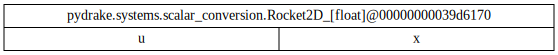

<pydrake.systems.framework.Diagram_[float] at 0x7efcac62e1f0>

In [ ]:
draw_rocket(np.array([0,10, np.pi / 3,0, 0, 0,0,0, 0, 0]))


In [ ]:
# repeated for convenience
RocketBargeState._fields

('x',
 'z',
 'theta',
 'fuel',
 'bargeX',
 'xdot',
 'zdot',
 'thetadot',
 'fueldot',
 'bargeXdot')

In [ ]:
def dircol_rocket(barge_speed_in, rocket_x_vel, theta, max_time, use_max_time, height_in):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[None]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"),
                                scene_graph)

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)

    
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-100, xmax=100, ymin=-10, ymax=100)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    x_traj = None
    u_traj = None

    # SNOPT is more reliable if we solve it twice.
    for N in [25, 41]:
    # for N in [61]:
        dircol = DirectCollocation(rocket, rocket.CreateDefaultContext(), N,
                                0.5 / N, 10.0 / N, assume_non_continuous_states_are_fixed=True)
        prog = dircol.prog()
        dircol.AddEqualTimeIntervalsConstraints()

        # Input limits
        u = dircol.input()
        dircol.AddConstraintToAllKnotPoints(u[0] <= 50)
        dircol.AddConstraintToAllKnotPoints(u[0] >= 0)
        dircol.AddConstraintToAllKnotPoints(u[1] <= 10)
        dircol.AddConstraintToAllKnotPoints(u[1] >= -10)

        barge_speed = barge_speed_in
        initial_fuel = 100

        # Initial conditions
        s0 = RocketBargeState(np.zeros(10))
        s0.z = height_in #50
        s0.x = -30
        s0.theta = theta #3.1415/2
        s0.xdot = rocket_x_vel #50
        s0.bargeX = 0
        s0.bargeXdot = barge_speed
        s0.fuel = initial_fuel

        
        prog.AddBoundingBoxConstraint(s0[:], s0[:], dircol.initial_state())
        context.SetContinuousState(s0[:])
        diagram.Publish(context)

        # Final conditions
        sf = RocketBargeState(dircol.final_state())
        prog.AddBoundingBoxConstraint(-2,2, sf.x)
        # dircol.AddLinearConstraint(sf.x <= 1)
        # dircol.AddLinearConstraint(sf.x >= -1)
        prog.AddBoundingBoxConstraint(5, 5, sf.z)
        prog.AddBoundingBoxConstraint(0,0, sf.theta)
        prog.AddBoundingBoxConstraint(0 , 0 , sf.xdot)
        prog.AddBoundingBoxConstraint(0, 0, sf.zdot)
        prog.AddBoundingBoxConstraint(0,0, sf.thetadot)

        # State constraints
        s = RocketBargeState(dircol.state())
        dircol.AddConstraintToAllKnotPoints(s.z >= 5)
        dircol.AddConstraintToAllKnotPoints(s.bargeXdot == barge_speed)
        dircol.AddConstraintToAllKnotPoints(s.fuel >= 0)

        # Cost
        # dircol.AddRunningCost(0.00001*(u[1]**2))
        # dircol.AddRunningCost(1000*(u[0] + 1000*(u[1]**2)**0.5))
        dircol.AddRunningCost((u[0]**2 + 100*u[1]**2))

        # time constraint
        if use_max_time:
            dircol.AddDurationBounds(0,max_time)


        sf_d = RocketBargeState(np.zeros(10))
        sf_d.fuel = initial_fuel
        prog.AddQuadraticErrorCost(np.diag([100, 0, 0, 1, 0, 0, 0, 0, 0,0]), sf_d[:],
                                dircol.final_state())

        # def plot_trajectory(times, states):
        #     s = RocketBargeState(states)
        #     vertices = np.vstack([s.x, 0*s.x, s.z])
        #     meshcat.SetLine("dircol", vertices, rgba=Rgba(0, 0, 0.5))

        # dircol.AddStateTrajectoryCallback(plot_trajectory)

        if x_traj and u_traj:
            dircol.SetInitialTrajectory(u_traj, x_traj)
        else:
            initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
                [0., .8], np.column_stack((s0[:], sf_d[:])))
            dircol.SetInitialTrajectory(PiecewisePolynomial(),
                                        initial_x_trajectory)

        options = SolverOptions()
        options.SetOption(CommonSolverOption.kPrintToConsole, 1)
        prog.SetSolverOptions(options)

        # print(prog)

        result = Solve(prog)
        infeasible_constraints = result.GetInfeasibleConstraints(prog)
        for c in infeasible_constraints:
            print(f"infeasible constraint: {c}")
        assert result.is_success()

        x_traj = dircol.ReconstructStateTrajectory(result)
        u_traj = dircol.ReconstructInputTrajectory(result)

    # Animate trajectory

    visualizer.StartRecording()
    for t in np.hstack((np.arange(x_traj.start_time(), x_traj.end_time(),
                                  1.0/32.0), x_traj.end_time())):
        context.SetTime(t)
        context.SetContinuousState(x_traj.value(t))
        diagram.Publish(context)

    visualizer.StopRecording()
    visualizer.PublishRecording()

    
    return x_traj, u_traj

barge_speed_in, rocket_x_vel, theta, max_time, use_max_time, height_in = [5,0,0,4,False,50]
x_traj, u_traj = dircol_rocket(barge_speed_in, rocket_x_vel, theta, max_time, use_max_time, height_in)

fuel used:  64.17446612804176
fuel used:  76.84793016307407
fuel used:  95.58421922531134
fuel used:  99.3176527381533
fuel used:  69.1911192302851


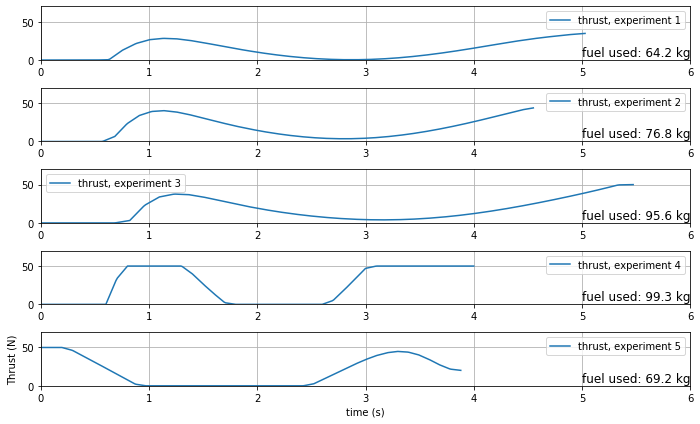

In [ ]:
# simulate different conditions for paper

fig, ax = plt.subplots(5,1, figsize=(10,6))

xlim_ = (0, 6)
ylim_ = (0, 70)
# Setting the values for all axes.
plt.setp(ax, xlim=xlim_, ylim=ylim_)

plt.ylabel("Thrust (N)")
plt.xlabel("time (s)")
#plt.title("Main Engine Thrust Curve")

barge_speed_in = 5
rocket_x_vel = 0
theta = 0
max_time = 4
use_max_time = True
height_in = 50

#barge_speed_in, rocket_x_vel, theta, max_time, use_max_time, height_in
params = [[5,0,0,4,False,50],[10,0,0,4,False,50],[10,0,0,4,False,100],
[10,0,0,4,True,100],[10,50,3.14/2,4,False,50]]

for i in range(5):
    barge_speed_in, rocket_x_vel, theta, max_time, use_max_time, height_in = params[i]
    temp_x_traj, temp_u_traj = dircol_rocket(barge_speed_in, rocket_x_vel, theta, max_time, use_max_time, height_in)

    ts = np.linspace(temp_u_traj.start_time(), temp_u_traj.end_time(), 301)
    s = RocketBargeState(temp_x_traj.vector_values(ts))
    u = temp_u_traj.vector_values(ts)

    ax[i].plot(ts, u[0], label='thrust, experiment '+str(i+1))
    ax[i].legend()
    ax[i].grid()
    fuel_used = initial_fuel-s.fuel[-1]
    print("fuel used: ", fuel_used)
    ax[i].text(5, 5, "fuel used: " + str(round(fuel_used,1)) + " kg", fontsize = 12)

fig.tight_layout()
initial_fuel = 100

# calculate total thrust and torque, NOTE: this only works if u's are evenly spaces in time
# total_time = u_traj.end_time() - u_traj.start_time() 
# total_thrust = total_time * sum(abs(u[0]))/len(u[0])
# total_torque = total_time * sum(abs(u[1]))/len(u[1])
# print("total time: ", total_time)
# print("total thrust: ", total_thrust)
# print("total torque: ", total_torque)

total time:  3.880263190927021
total thrust:  69.41371116524202
total torque:  4.707786295886683


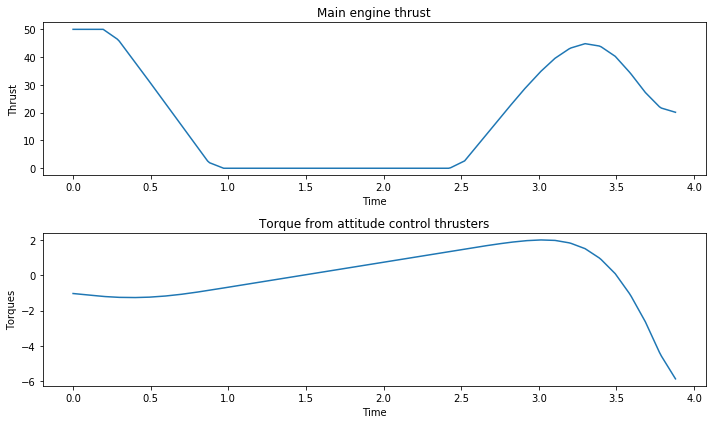

In [ ]:
ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
s = RocketBargeState(x_traj.vector_values(ts))
u = u_traj.vector_values(ts)

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(ts, u[0])
ax[0].title.set_text("Main engine thrust")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Thrust")
ax[1].plot(ts, u[1])
ax[1].title.set_text("Torque from attitude control thrusters")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Torques")
fig.tight_layout()

# calculate total thrust and torque, NOTE: this only works if u's are evenly spaces in time
total_time = u_traj.end_time() - u_traj.start_time() 
total_thrust = total_time * sum(abs(u[0]))/len(u[0])
total_torque = total_time * sum(abs(u[1]))/len(u[1])
print("total time: ", total_time)
print("total thrust: ", total_thrust)
print("total torque: ", total_torque)

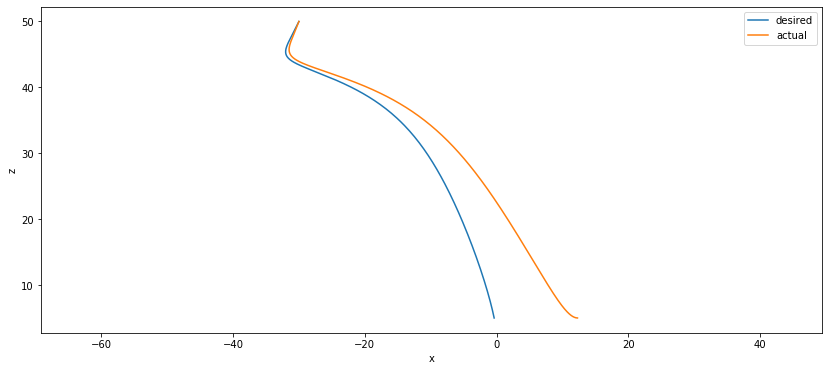

In [ ]:
def open_loop_simulation(x_traj, u_traj):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[None]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"),
                                scene_graph)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    logger = LogVectorOutput(rocket.GetOutputPort("x"), builder)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-100, xmax=100, ymin=-10, ymax=100)

    traj = builder.AddSystem(TrajectorySource(u_traj))
    builder.Connect(traj.get_output_port(), rocket.get_input_port())
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    rocket_context = rocket.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = RocketBargeState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(desired_state.x, desired_state.z, label='desired')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.axis('equal')

    context.SetTime(x_traj.start_time())
    initial_state = RocketBargeState(x_traj.value(x_traj.start_time()))
    initial_state.bargeXdot -= 1 # set the barge velocity to something differnt
    rocket_context.SetContinuousState(initial_state[:])

    visualizer.StartRecording(False)
    simulator.AdvanceTo(x_traj.end_time())
    visualizer.PublishRecording()

    log = logger.FindLog(context)
    state = RocketBargeState(log.data())
    ax.plot(state.x, state.z, label=f'actual')
    ax.legend()

open_loop_simulation(x_traj, u_traj)

In [ ]:
x_traj.end_time()

3.880263190927021

barge speed 0 = [4.99317322]
(10, 751)
barge speed 1 = [6.04614329]
(10, 803)
barge speed 2 = [5.74158842]
(10, 783)
barge speed 3 = [5.72395654]
(10, 785)
barge speed 4 = [6.61877622]
(10, 827)


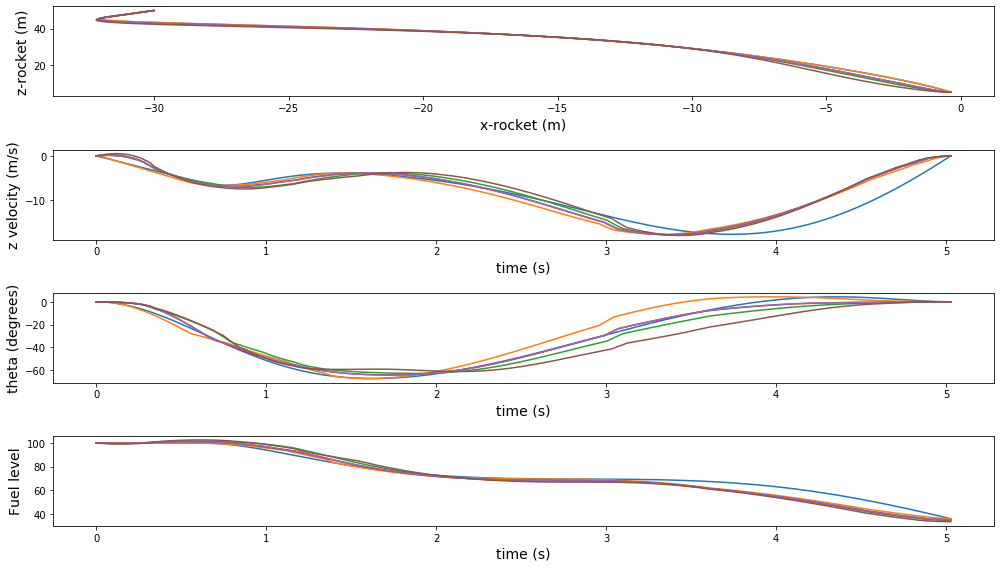

In [ ]:
def finite_horizon_lqr(x_traj, u_traj):
    builder = DiagramBuilder()
    rocket = builder.AddSystem(Rocket2D_[None]())
    scene_graph = builder.AddSystem(SceneGraph())
    RocketGeometry.AddToBuilder(builder, rocket.GetOutputPort("x"),
                                scene_graph)
    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    logger = LogVectorOutput(rocket.GetOutputPort("x"), builder)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-100, xmax=100, ymin=-10, ymax=100)

    Q = np.diag([10, 10, 10, 10, 0, 1, 1, 100, 10, 0])
    R = np.diag([0.01, 0.01])
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.Qf = np.diag([(1 / 0.05)**2, (1 / 0.05)**2, (1 / 0.001)**2, (1 / 100)**2,
                          0, (1/0.05)**2, (1/0.05)**2, (1 / 0.05 )**2, 0, 0])
    #options.use_square_root_method = True  # Pending drake PR #16812
    options.x0 = x_traj
    options.u0 = u_traj

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            system=rocket,
            context=rocket.CreateDefaultContext(),
            t0=x_traj.start_time(),
            tf=x_traj.end_time(),
            Q=Q,
            R=R,
            options=options))
    builder.Connect(controller.get_output_port(), rocket.get_input_port())
    builder.Connect(rocket.GetOutputPort("x"), controller.get_input_port())

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    rocket_context = rocket.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = RocketBargeState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(4,1, figsize=(14,8))
    ax[0].plot(desired_state.x, desired_state.z, label='desired')
    ax[0].set_xlabel('x-rocket (m)', fontsize = 14)
    ax[0].set_ylabel('z-rocket (m)', fontsize = 14)
    ax[1].plot(ts, desired_state.zdot, label='desired')
    ax[1].set_xlabel('time (s)', fontsize = 14)
    ax[1].set_ylabel('z velocity (m/s)', fontsize = 14)
    ax[2].plot(ts, desired_state.theta * 180/np.pi, label='desired')
    ax[2].set_xlabel('time (s)', fontsize = 14)
    ax[2].set_ylabel('theta (degrees)', fontsize = 14)
    ax[3].plot(ts, desired_state.fuel, label='desired')
    ax[3].set_xlabel('time (s)', fontsize = 14)
    ax[3].set_ylabel('Fuel level', fontsize = 14)

    

    rng = np.random.default_rng(12)

    for i in range(5):
        context.SetTime(x_traj.start_time())
        initial_state = RocketBargeState(x_traj.value(x_traj.start_time()))
        initial_state.bargeXdot += 1*rng.standard_normal()
        print(f"barge speed {i} =",initial_state.bargeXdot)
        # initial_state.bargeXdot -=         
        rocket_context.SetContinuousState(initial_state[:])

        simulator.Initialize()
        visualizer.StartRecording(False)

        simulator.AdvanceTo(x_traj.end_time())
        visualizer.PublishRecording()

        log = logger.FindLog(context)
        state = RocketBargeState(log.data())
        testTs = np.linspace(x_traj.start_time(), x_traj.end_time(), log.data().shape[1])

        print(log.data().shape)

        log.Clear()


        ax[0].plot(state.x, state.z, label=f'actual{i}')
        ax[1].plot(testTs, state.zdot, label=f'actual{i}')
        ax[2].plot(testTs, state.theta * 180/np.pi, label=f'actual{i}')
        ax[3].plot(testTs, state.fuel, label=f'actual{i}')
        
    
    # ax[0].legend()
    # ax[1].legend()
    # ax[2].legend()
    # ax[3].legend()
    fig.tight_layout()


finite_horizon_lqr(x_traj, u_traj)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=48a3d090-8efd-4fd5-9847-d5e27a9acb16' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>